In [1]:
from skimage import morphology
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import load_images
from image_utils import remove_small_components, find_branchpoints, blood_vessel_thickness
from skimage.morphology import skeletonize
from scipy.ndimage import binary_hit_or_miss, rotate
from pystackreg import StackReg
from skimage import io

In [7]:
import numpy as np

def generate_branching_kernels():
    kernels = []
    patterns = [
        [[0, 0, 1],
         [1, 1, 0],
         [0, 1, 0]],

        [[0, 1, 0],
         [1, 1, 1],
         [0, 1, 0]],

        [[1, 0, 1],
         [0, 1, 0],
         [1, 0, 1]], 

        [[0, 1, 0],
         [1, 1, 0],
         [0, 1, 0]],

        [[0, 1, 0],
         [0, 1, 0],
         [0, 1, 1]],

        [[1, 0, 1],
         [0, 1, 0],
         [1, 0, 0]],
    ]

    for pattern in patterns:
        for _ in range(4):
            kernels.append(pattern)
            kernels.append(np.fliplr(pattern))
            pattern = np.rot90(pattern)

    arr_list = np.array(kernels)
    unique_arrays = np.unique(arr_list, axis=0)
    return unique_arrays

In [2]:
def find_vessel_widths(binary_image):
    distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    skeleton = skeletonize(binary_image > 127)
    return distance_transform * skeleton

In [3]:
def rigid_registration(ref, mov):
    sr = StackReg(StackReg.RIGID_BODY)
    out_rot = sr.register_transform(ref, mov)
    return out_rot

In [41]:
def find_branchpoints(image):
    kernels = generate_branching_kernels()
    coords_x, coords_y = [], []
    for kernel in kernels:
        branch_points = binary_hit_or_miss(image, kernel)
        y, x  = np.nonzero(branch_points)
        coords_x.append(y)
        coords_y.append(x)
        
    return (np.concatenate(coords_x).tolist(), np.concatenate(coords_y).tolist())

In [5]:
preop_seg_imgs_path = '..\pre_op_segmented'
postop_seg_imgs_path = '..\post_op_segmented'

preop = load_images(preop_seg_imgs_path)
postop = load_images(postop_seg_imgs_path)
preop_vw = []
postop_vw = []

for i in range(len(preop)):
    preop[i] = remove_small_components(preop[i])
    postop[i] = remove_small_components(postop[i])
    preop_vw.append(find_vessel_widths(preop[i]))
    postop_vw.append(find_vessel_widths(postop[i]))

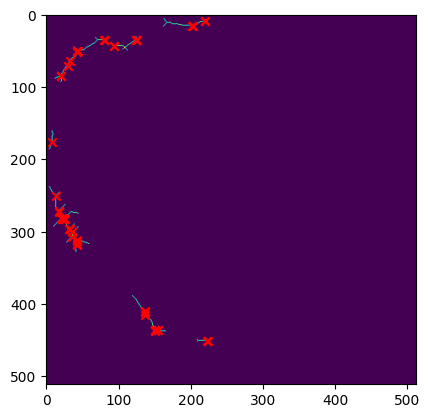

In [43]:
pr, po, pr_vw, po_vw = preop[0], postop[0], preop_vw[0], postop_vw[0]

width_lower = 3
width_upper = 8
step_size = 0.5

small_component_size = 20

for width in reversed(np.arange(width_lower, width_upper, step_size)):
    filtered_pr_vw, filtered_po_vw = remove_small_components(pr_vw > width, small_component_size), remove_small_components(pr_vw > width, small_component_size)
    registered_pr = rigid_registration(filtered_pr_vw, filtered_po_vw)
    bps_x, bps_y = find_branchpoints(filtered_pr_vw)
     